Dataset loading and preparing


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from matplotlib import cm
import random
import time
%matplotlib inline

In [ ]:
data= np.load('/content/drive/MyDrive/RAVDESS fusion labelled data.npy', allow_pickle=True)

In [ ]:
data_dict = data.item()
video_features = data_dict['video_features']
audio_features = data_dict['audio_features']
labels = data_dict['labels']

In [ ]:
print(video_features.shape)
print(audio_features.shape)
print(labels.shape)

(1440, 6, 64, 64, 3)
(1440, 181)
(1440,)


In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
lb = LabelEncoder()
labels = to_categorical(lb.fit_transform(labels))
print(labels.shape)

(1440, 8)


In [ ]:
audio_features=audio_features.reshape(1440,181,1)
print("Audio representation shape:",audio_features.shape)

Audio representation shape: (1440, 181, 1)


In [ ]:
from sklearn.model_selection import train_test_split
video_features_train, video_features_val,audio_features_train, audio_features_val,labels_train, labels_val = train_test_split(video_features,audio_features,labels, test_size=0.2,random_state=0)
video_features_val, video_features_test,audio_features_val, audio_features_test,labels_val, labels_test = train_test_split(video_features_val,audio_features_val,labels_val, test_size=0.5,random_state=0)

In [ ]:
print(video_features_train.shape)
print(video_features_val.shape)
print(video_features_test.shape)
print(audio_features_train.shape)
print(audio_features_val.shape)
print(audio_features_test.shape)
print(labels_train.shape)
print(labels_val.shape)
print(labels_test.shape)

(1152, 6, 64, 64, 3)
(144, 6, 64, 64, 3)
(144, 6, 64, 64, 3)
(1152, 181, 1)
(144, 181, 1)
(144, 181, 1)
(1152, 8)
(144, 8)
(144, 8)


Video model

In [ ]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *

In [ ]:
input_video = Input(shape=(6,64,64,3))
    
conv = ConvLSTM2D(64, 3, activation='relu', padding = 'same')(input_video)
conv= Convolution2D(64, 3, activation='relu', padding = 'same')(conv)
pool = MaxPooling2D((2, 2), strides=(2, 2))(conv)
    
conv = Convolution2D(128, 3, activation='relu', padding = 'same')(pool)
pool = MaxPooling2D((2, 2), strides=(2, 2))(conv)
conv = Convolution2D(128, 3, activation='relu', padding = 'same')(pool)
pool = MaxPooling2D((2, 2), strides=(2, 2))(conv)
    
conv = Convolution2D(256, 3, activation='relu', padding = 'same')(pool)
#conv3 = Convolution2D(256, 3, activation='relu', padding = 'same')(conv3)
#conv3 = Convolution2D(256, 3, activation='relu', padding = 'same')(conv3)
pool = MaxPooling2D((2, 2), strides=(2, 2))(conv)

conv = Convolution2D(512, 3, activation='relu', padding = 'same')(pool)
#conv4 = Convolution2D(512, 3, activation='relu', padding = 'same')(conv4)
#conv4 = Convolution2D(512, 3, activation='relu', padding = 'same')(conv4)
pool = MaxPooling2D((2, 2), strides=(2, 2))(conv)
    
output_video = Flatten()(pool)

Audio model

In [ ]:
from tensorflow.keras.regularizers import l2
input_audio = Input(shape=(181,1))
    
conv = Convolution1D(64, 10, activation='relu')(input_audio)
conv = Convolution1D(128, 10, activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(conv)
pool = MaxPooling1D((8))(conv)
drop = Dropout(0.4)(pool)
    
output_audio = Flatten()(drop)

Concatenation

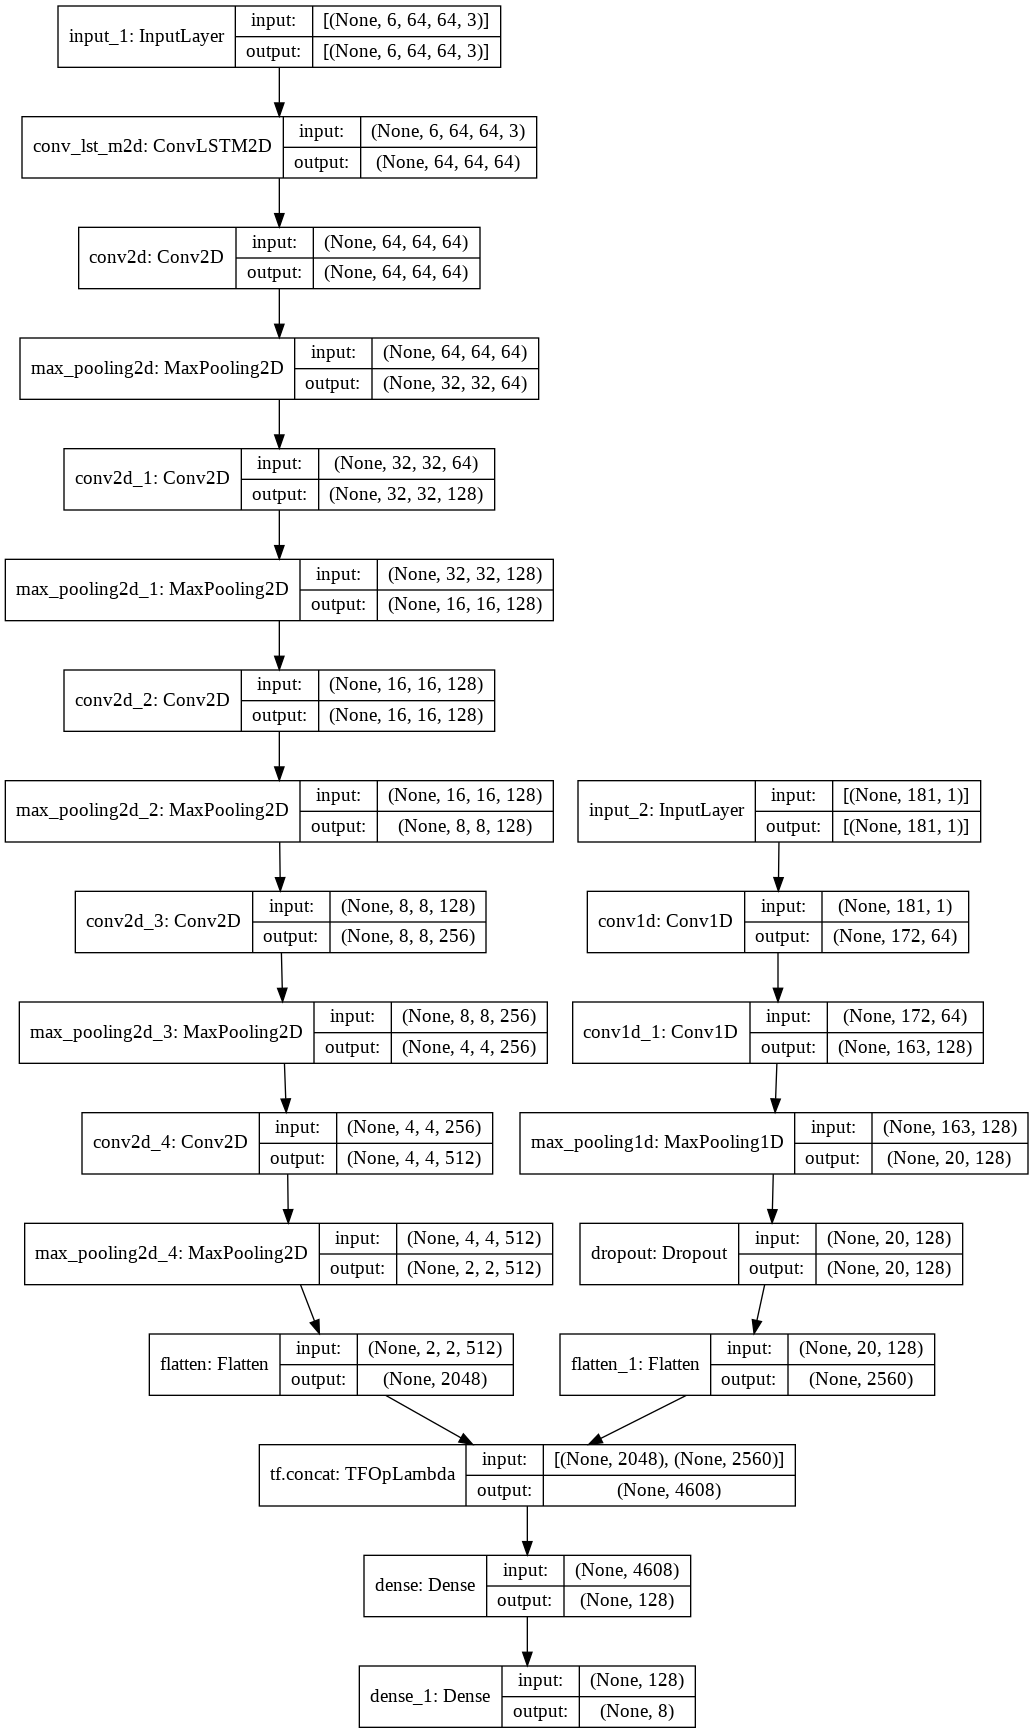

In [ ]:
#Now concatenate all the layers to make a multimodal
concatenate = keras.layers.Concatenate()([output_video, output_audio])
final_layer = Dense(128, activation='relu')(concatenate)
y_predict_emotions = Dense(8, activation='softmax')(final_layer)
model = Model(inputs=[input_video, input_audio], outputs=[y_predict_emotions])
tf.keras.utils.plot_model(model, to_file='multimodal model.png', show_shapes=True, show_layer_names=True)

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = opt , loss = 'categorical_crossentropy', metrics = ['accuracy'])
start=time.time()
history = model.fit([video_features_train,audio_features_train],labels_train,
                    epochs = 120, 
                    batch_size=32,
                    validation_data=([video_features_val,audio_features_val],labels_val))
end=time.time()
train_time_avg=(end-start)/120

Epoch 1/120
36/36 [==============================] - 47s 368ms/step - loss: 2.8134 - accuracy: 0.2109 - val_loss: 2.4078 - val_accuracy: 0.2917
Epoch 2/120
36/36 [==============================] - 12s 346ms/step - loss: 2.2604 - accuracy: 0.2951 - val_loss: 2.1129 - val_accuracy: 0.3333
Epoch 3/120
36/36 [==============================] - 12s 347ms/step - loss: 2.0317 - accuracy: 0.3594 - val_loss: 1.9988 - val_accuracy: 0.3056
Epoch 4/120
36/36 [==============================] - 13s 349ms/step - loss: 1.8974 - accuracy: 0.3585 - val_loss: 1.8891 - val_accuracy: 0.3542
Epoch 5/120
36/36 [==============================] - 13s 349ms/step - loss: 1.7797 - accuracy: 0.4089 - val_loss: 1.7639 - val_accuracy: 0.4028
Epoch 6/120
36/36 [==============================] - 13s 350ms/step - loss: 1.6548 - accuracy: 0.4766 - val_loss: 1.6324 - val_accuracy: 0.4375
Epoch 7/120
36/36 [==============================] - 13s 349ms/step - loss: 1.5687 - accuracy: 0.5000 - val_loss: 1.6284 - val_accuracy:

In [ ]:
start=time.time()
score=model.evaluate([video_features_test,audio_features_test],labels_test)
end=time.time()
test_time=end-start
print("Test loss of the model is - " , score[0])
print("Test accuracy of the model is - " , score[1]*100 , "%")

5/5 [==============================] - 1s 105ms/step - loss: 1.0878 - accuracy: 0.7569
Test loss of the model is -  1.0878195762634277
Test accuracy of the model is -  75.69444179534912 %


In [ ]:
print(train_time_avg)
print(test_time)

13.200651961565018
0.6317250728607178


In [ ]:
from sklearn.metrics import confusion_matrix
predictions = model.predict([video_features_test,audio_features_test])
predictions = predictions.argmax(axis=1)
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
actual = labels_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
cm = confusion_matrix(actual, predictions,labels=[1,2,3,4,5,6,7,8],normalize='true')
conf_matrix= pd.DataFrame(cm,index=[1,2,3,4,5,6,7,8],columns=[1,2,3,4,5,6,7,8])
conf_matrix.to_csv(r'confusion_matrix.csv', index = True, header=True)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(actual, predictions, target_names = ['1','2','3','4','5','6','7','8']))

              precision    recall  f1-score   support

           1       0.83      0.67      0.74        15
           2       0.75      0.78      0.77        23
           3       0.79      0.73      0.76        15
           4       0.50      0.76      0.60        17
           5       0.88      0.82      0.85        17
           6       0.93      0.70      0.80        20
           7       0.76      0.76      0.76        17
           8       0.80      0.80      0.80        20

    accuracy                           0.76       144
   macro avg       0.78      0.75      0.76       144
weighted avg       0.78      0.76      0.76       144



In [ ]:
from imblearn.metrics import specificity_score
s=specificity_score(actual,predictions,average='macro')
print(s)

0.965215581670032


In [ ]:
from sklearn.metrics import roc_auc_score
y_score=model.predict([video_features_test,audio_features_test])
auc=roc_auc_score(labels_test, y_score, average='macro',multi_class='ovo')
print(auc)

0.9544910064258181


In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
p=precision_score(actual,predictions,average='macro')
r=recall_score(actual,predictions,average='macro')
f=f1_score(actual,predictions,average='macro')
print(p,r,f)

0.7802608543417366 0.7544437340153453 0.760395096354114


In [ ]:
from numpy import interp
from sklearn.metrics import roc_curve
fpr = dict()
tpr = dict()
classes=8
y_score=model.predict([video_features_test,audio_features_test])
for i in range(classes):
  fpr[i], tpr[i], _ = roc_curve(labels_test[:, i], y_score[:, i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr

In [ ]:
l=[]
for i in range(120):
  l.append(i+1)

In [ ]:
from pandas import DataFrame
C = {'epoch no':l,
    'acc train':history.history['accuracy'],
    'acc val':history.history['val_accuracy'],
    'loss train':history.history['loss'],
    'loss val':history.history['val_loss']}
df = DataFrame(C, columns= ['epoch no','acc train','acc val','loss train','loss val'])
export_csv = df.to_csv (r'result1.csv', index = None, header=True) 
print (df)

     epoch no  acc train   acc val  loss train  loss val
0           1   0.210938  0.291667    2.813440  2.407817
1           2   0.295139  0.333333    2.260415  2.112893
2           3   0.359375  0.305556    2.031688  1.998776
3           4   0.358507  0.354167    1.897412  1.889116
4           5   0.408854  0.402778    1.779685  1.763939
..        ...        ...       ...         ...       ...
115       116   0.956597  0.618056    0.339483  1.582084
116       117   0.943576  0.638889    0.368246  1.509507
117       118   0.946181  0.680556    0.351112  1.513736
118       119   0.953993  0.638889    0.349630  1.665274
119       120   0.944444  0.631944    0.360322  1.514628

[120 rows x 5 columns]


In [ ]:
C = {
     'train acc':[str(history.history['accuracy'][119])],
     'test acc':[str(score[1])],
     'precision(macro)':[str(p)],
     'recall(macro)':[str(r)],
     'f1(macro)':[str(f)],
     'specificity(macro)':[str(s)],
     'AUC(macro)':[str(auc)],
     'average train time(s)':[str(train_time_avg)],
     'test time(s)':[str(test_time)],}
df = DataFrame(C, columns= ['train acc','test acc','precision(macro)','recall(macro)','f1(macro)','specificity(macro)','AUC(macro)','average train time(s)','test time(s)'])
export_csv = df.to_csv (r'result2.csv', index = None, header=True) 
print (df)

            train acc  ...        test time(s)
0  0.9444444179534912  ...  0.6317250728607178

[1 rows x 9 columns]


In [ ]:
C = {
     'TPR(macro)': tpr['macro'],
     'FPR(macro)': fpr['macro']}
df = DataFrame(C, columns= ['TPR(macro)','FPR(macro)'])
export_csv = df.to_csv (r'result3.csv', index = None, header=True) 
print (df)

    TPR(macro)  FPR(macro)
0     0.446249    0.000000
1     0.475661    0.007874
2     0.538161    0.008065
3     0.559900    0.008264
4     0.618233    0.015504
5     0.632939    0.015748
6     0.670983    0.016529
7     0.679316    0.023256
8     0.701375    0.023622
9     0.713875    0.024194
10    0.730179    0.024793
11    0.755179    0.031008
12    0.784591    0.031496
13    0.792924    0.038760
14    0.800277    0.039370
15    0.819027    0.040323
16    0.833733    0.055118
17    0.839983    0.056452
18    0.848316    0.062016
19    0.854566    0.072581
20    0.861919    0.078740
21    0.867354    0.090909
22    0.874707    0.094488
23    0.880957    0.104839
24    0.889290    0.108527
25    0.896643    0.110236
26    0.907513    0.132231
27    0.912948    0.148760
28    0.920301    0.149606
29    0.926551    0.153226
30    0.941256    0.157480
31    0.946691    0.181818
32    0.954044    0.307087
33    0.962377    0.310078
34    0.968627    0.322581
35    0.975980    0.425197
3